In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
from sklearn.decomposition import PCA
# import own modules
from src.mnist import Mnist
from src.nntorch import MLP

In [2]:
# Set device
device = torch.device("cpu")

# Set the number of threads to the maximum available
num_cores = torch.get_num_threads()
torch.set_num_threads(num_cores)

In [3]:
# Create an instance of the Mnist class
db = Mnist(fileName='data/mnist.pkl.gz')
batch_size = 100
train_batches = db.getBatches(db.X_train, db.y_train, batch_size, tensor=True)
val_batches = db.getBatches(db.X_val, db.y_val, batch_size, tensor=True)
test_batches = db.getBatches(db.X_test, db.y_test, batch_size, tensor=True)

In [4]:
# augmentations (on training set)
X_train_aug, y_train_aug = db.augment(inputs=db.X_train, labels=db.y_train, n_aug=5)
# add augmented data to the training set
X_train_aug = np.vstack((db.X_train, X_train_aug))
y_train_aug = np.hstack((db.y_train, y_train_aug))
# create batches from augmented data
train_batches_aug = db.getBatches(X_train_aug, y_train_aug, batch_size, tensor=True)

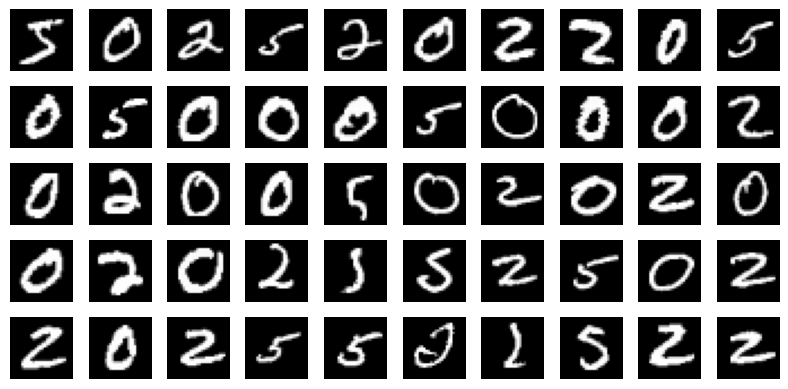

In [22]:
# plot some augmented digits
# filter digits: 0, 2 and 5
X_train_aug_filtered = X_train_aug[np.isin(y_train_aug, [0, 2, 5])]
Mnist.plotDigits(X_train_aug_filtered[:50], max_cols=10, file_name='figures/augment/mnist_augment.png', figsize=(8, 4))

In [7]:
layers = [784, 50, 10]
activations = [F.sigmoid]
loss_fn = nn.CrossEntropyLoss
epochs = 400
lr = 1.44e-2
lmbda = 1.3e-6

model_1hl = MLP(sizes=layers, activations=activations, loss_fn=loss_fn)
metrics_1hl = model_1hl.train(train_batches_aug, optimizer=optim.Adam, epochs=epochs, lr=lr, regularization=lmbda, 
                               eval_batches=val_batches, monitor_train=True, verbose=True, epch_print=50)

Epoch 25/400: Loss (1.528, 1.499) 	 Accuracy (93.46%, 96.31%)
Epoch 50/400: Loss (1.525, 1.497) 	 Accuracy (93.74%, 96.57%)
Epoch 75/400: Loss (1.523, 1.496) 	 Accuracy (93.99%, 96.56%)
Epoch 100/400: Loss (1.533, 1.5) 	 Accuracy (92.95%, 96.28%)
Epoch 125/400: Loss (1.522, 1.496) 	 Accuracy (94.02%, 96.61%)
Epoch 150/400: Loss (1.529, 1.499) 	 Accuracy (93.36%, 96.28%)
Epoch 175/400: Loss (1.528, 1.499) 	 Accuracy (93.46%, 96.27%)
Epoch 200/400: Loss (1.527, 1.5) 	 Accuracy (93.55%, 96.11%)
Epoch 225/400: Loss (1.532, 1.503) 	 Accuracy (93.06%, 95.93%)
Epoch 250/400: Loss (1.528, 1.502) 	 Accuracy (93.45%, 96.14%)
Epoch 275/400: Loss (1.527, 1.497) 	 Accuracy (93.55%, 96.51%)
Epoch 300/400: Loss (1.527, 1.5) 	 Accuracy (93.54%, 96.20%)
Epoch 325/400: Loss (1.528, 1.501) 	 Accuracy (93.45%, 96.09%)
Epoch 350/400: Loss (1.534, 1.502) 	 Accuracy (92.87%, 96.01%)
Epoch 375/400: Loss (1.525, 1.497) 	 Accuracy (93.76%, 96.59%)
Epoch 400/400: Loss (1.527, 1.497) 	 Accuracy (93.60%, 96.50%)


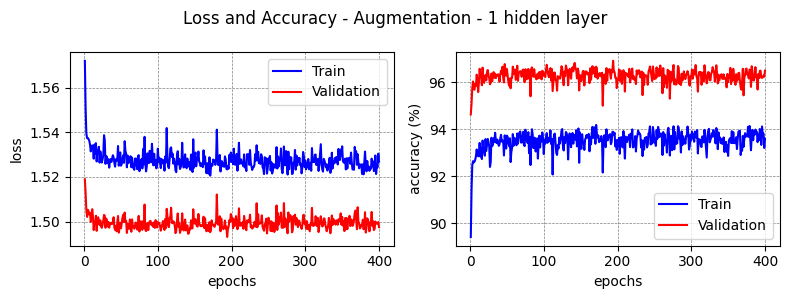

In [8]:
# plot the loss and accuracy togheter in two subplots horizontally
epochs_vec = range(1, epochs+1)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(epochs_vec, metrics_1hl['loss'][0], c='blue', ls='-', label='Train')
axs[0].plot(epochs_vec, metrics_1hl['loss'][1], c='red', ls='-', label='Validation')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].legend(loc='best')
axs[0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1].plot(epochs_vec, 100*np.array(metrics_1hl['accuracy'][0]), c='blue', ls='-', label='Train')
axs[1].plot(epochs_vec, 100*np.array(metrics_1hl['accuracy'][1]), c='red', ls='-', label='Validation')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy (%)')
axs[1].legend(loc='best')
axs[1].grid(color='gray', linestyle='--', linewidth=0.5)
plt.suptitle('Loss and Accuracy - Augmentation - 1 hidden layer')
plt.tight_layout()
plt.savefig("figures/augment/loss_accuracy_augmentation_1hl.png")
plt.show()

In [10]:
print('Accuracy results - 1 hidden layer:')
print("-"*25)
print('Train: {:.2f}%'.format(100*model_1hl.accuracy(train_batches_aug)))
print('Validation: {:.2f}%'.format(100*model_1hl.accuracy(val_batches)))
print('Test: {:.2f}%'.format(100*model_1hl.accuracy(test_batches)))

Accuracy results - 1 hidden layer:
-------------------------
Train: 93.60%
Validation: 96.50%
Test: 96.53%


In [35]:
n_aug_vec = np.linspace(1, 7, 7).astype(int)
layers = [784, 50, 10]
activations = [F.sigmoid]
criterion = nn.CrossEntropyLoss
epochs = 200
lr = 1.44e-2
lmbda = 1.3e-6

In [38]:
metrics_aug = []
for n_aug in n_aug_vec:
    # create augmented data
    X_train_aug, y_train_aug = db.augment(inputs=db.X_train, labels=db.y_train, n_aug=n_aug)
    X_val_aug, y_val_aug = db.augment(inputs=db.X_val, labels=db.y_val, n_aug=n_aug)
    # add augmented data to the training set
    X_train_aug = np.vstack((db.X_train, X_train_aug))
    y_train_aug = np.hstack((db.y_train, y_train_aug))
    # add augmented data to the validation set
    X_val_aug = np.vstack((db.X_val, X_val_aug))
    y_val_aug = np.hstack((db.y_val, y_val_aug))
    # create batches from augmented data
    train_batches_aug = db.getBatches(X_train_aug, y_train_aug, batch_size, tensor=True)
    val_batches_aug = db.getBatches(X_val_aug, y_val_aug, batch_size, tensor=True)

    model_aug = MLP(sizes=layers, activations=activations, loss_fn=criterion, params="normal")
    metrics_aug.append(model_aug.train(train_batches_aug, optimizer=optim.Adam, epochs=epochs, lr=lr, regularization=lmbda, 
                                       eval_batches=val_batches_aug, monitor_train=True, only_last=True))
    print(f'Augmentation: {n_aug} completed.')

Augmentation: 1 completed.
Augmentation: 2 completed.
Augmentation: 3 completed.
Augmentation: 4 completed.
Augmentation: 5 completed.
Augmentation: 6 completed.
Augmentation: 7 completed.


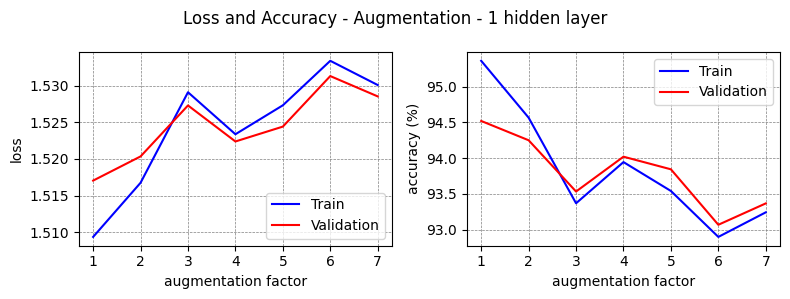

In [39]:
# plot accuracy and loss against the augmentation factor
loss_train_aug = [metric['loss'][0][-1] for metric in metrics_aug]
loss_val_aug = [metric['loss'][1][-1] for metric in metrics_aug]
acc_train_aug = [100*metric['accuracy'][0][-1] for metric in metrics_aug]
acc_val_aug = [100*metric['accuracy'][1][-1] for metric in metrics_aug]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(n_aug_vec, loss_train_aug, c='blue', ls='-', label='Train')
axs[0].plot(n_aug_vec, loss_val_aug, c='red', ls='-', label='Validation')
axs[0].set_xlabel('augmentation factor')
axs[0].set_ylabel('loss')
axs[0].legend(loc='best')
axs[0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1].plot(n_aug_vec, acc_train_aug, c='blue', ls='-', label='Train')
axs[1].plot(n_aug_vec, acc_val_aug, c='red', ls='-', label='Validation')
axs[1].set_xlabel('augmentation factor')
axs[1].set_ylabel('accuracy (%)')
axs[1].legend(loc='best')
axs[1].grid(color='gray', linestyle='--', linewidth=0.5)
plt.suptitle('Loss and Accuracy - Augmentation - 1 hidden layer')
plt.tight_layout()
plt.savefig("figures/augment/loss_accuracy_augmentation_1hl.png")
plt.show()

In [7]:
variance = 0.95
n_components = db.getNumComponentsPCA(variance)
X = np.vstack([db.X_train, db.X_val, db.X_test])
pca = PCA(n_components=variance)
pca.fit(X)

# augmentations (on training set)
X_train_aug, y_train_aug = db.augment(inputs=db.X_train, labels=db.y_train, n_aug=5)
X_val_aug, y_val_aug = db.augment(inputs=db.X_val, labels=db.y_val, n_aug=5)
# add augmented data to the training set
X_train_aug = np.vstack((db.X_train, X_train_aug))
y_train_aug = np.hstack((db.y_train, y_train_aug))
# add augmented data to the validation set
X_val_aug = np.vstack((db.X_val, X_val_aug))
y_val_aug = np.hstack((db.y_val, y_val_aug))
# transform data (reduce dimensionality - PCA)
X_train_aug_pca = pca.transform(X_train_aug)
X_val_aug_pca = pca.transform(X_val_aug)
# create batches from augmented data
train_batches_aug_pca = db.getBatches(X_train_aug_pca, y_train_aug, batch_size, tensor=True)
val_batches_aug_pca = db.getBatches(X_val_aug_pca, y_val_aug, batch_size, tensor=True)
test_batches_pca = db.getBatches(pca.transform(db.X_test), db.y_test, batch_size, tensor=True)

In [5]:
# fit model with 1 hidden layer
layers = [n_components, 50, 10]
activations = [F.sigmoid]
criterion = nn.CrossEntropyLoss
epochs = 400
lr = 1.44e-2
lmbda = 1.3e-6

model_1hl_pca = MLP(sizes=layers, activations=activations, loss_fn=criterion, params="normal")
metrics_1hl_pca = model_1hl_pca.train(train_batches_aug_pca, optimizer=optim.Adam, epochs=epochs, 
                                      lr=lr, regularization=lmbda, eval_batches=val_batches_aug_pca, 
                                      monitor_train=True, verbose=True, epch_print=50)

Epoch 50/400: Loss (1.511, 1.514) 	 Accuracy (95.18%, 94.88%)
Epoch 100/400: Loss (1.508, 1.512) 	 Accuracy (95.52%, 95.03%)
Epoch 150/400: Loss (1.506, 1.511) 	 Accuracy (95.70%, 95.16%)
Epoch 200/400: Loss (1.507, 1.511) 	 Accuracy (95.62%, 95.17%)
Epoch 250/400: Loss (1.506, 1.51) 	 Accuracy (95.73%, 95.30%)
Epoch 300/400: Loss (1.506, 1.51) 	 Accuracy (95.71%, 95.28%)
Epoch 350/400: Loss (1.506, 1.51) 	 Accuracy (95.70%, 95.23%)
Epoch 400/400: Loss (1.505, 1.51) 	 Accuracy (95.76%, 95.24%)


In [10]:
print('Accuracy results - 1 hidden layer (PCA):')
print("-"*50)
print('Train: {:.2f}%'.format(100*model_1hl_pca.accuracy(train_batches_aug_pca)))
print('Validation: {:.2f}%'.format(100*model_1hl_pca.accuracy(val_batches_aug_pca)))
print('Test: {:.2f}%'.format(100*model_1hl_pca.accuracy(test_batches_pca)))

Accuracy results - 1 hidden layer (PCA):
--------------------------------------------------
Train: 95.12%
Validation: 95.34%
Test: 97.25%


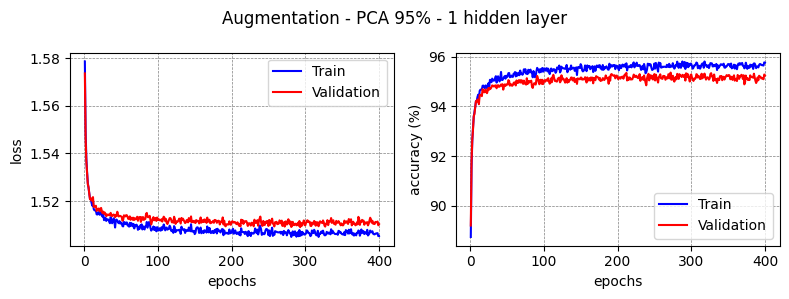

In [9]:
# plot the loss and accuracy togheter in two subplots horizontally
epochs_vec = range(1, epochs+1)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(epochs_vec, metrics_1hl_pca['loss'][0], c='blue', ls='-', label='Train')
axs[0].plot(epochs_vec, metrics_1hl_pca['loss'][1], c='red', ls='-', label='Validation')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].legend(loc='best')
axs[0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1].plot(epochs_vec, 100*np.array(metrics_1hl_pca['accuracy'][0]), c='blue', ls='-', label='Train')
axs[1].plot(epochs_vec, 100*np.array(metrics_1hl_pca['accuracy'][1]), c='red', ls='-', label='Validation')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy (%)')
axs[1].legend(loc='best')
axs[1].grid(color='gray', linestyle='--', linewidth=0.5)
plt.suptitle('Augmentation - PCA 95% - 1 hidden layer')
plt.tight_layout()
plt.savefig("figures/augment/augmentation_pca95_1hl.png")
plt.show()